In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
q = os.path.abspath('../../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import InpaintDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/inpainting/v2/baseline/checkpoint.pt'
model = VAE((1, 80, 80, 96), 100, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = '/neurospin/dico/data/deep_folding/current/datasets/' \
                        'hcp/crops/1mm/SC/no_mask/'

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

filenames = np.load(os.path.join(data_dir,"Rfoldlabels", "sub_id.npy"))
distmaps = np.load(os.path.join(data_dir, 'Rskel_distmaps_junction', "Rskel_distmaps.npy"),
                   mmap_mode='r')

skeletons = np.load(os.path.join(data_dir, "Rskeletons_junction",
                                "Rskeleton.npy"),
                   mmap_mode='r')

foldlabels = np.load(os.path.join('/neurospin/dico/data/deep_folding/current/datasets/hcp/foldlabels/raw/junction/crops/',
                                    "Rlabels.npy"),
                   mmap_mode='r')
    
print(distmaps.shape, filenames.shape)

# Selection of test set only
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, np.array(test_list['subjects']), sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]
skeletons = skeletons[filenames_idx]
foldlabels = foldlabels[filenames_idx]

print(distmaps.shape)

(1114, 78, 63, 88, 1) (1114,)
(200, 78, 63, 88, 1)


In [5]:
subset = InpaintDataset(foldlabels=foldlabels,
                        skeletons=skeletons,
                        distmaps=distmaps,
                        filenames=filenames,
                        data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [6]:
""" SC INT """
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])

filenames_scint = np.load(os.path.join(data_dir, "Rfoldlabels", "sub_id.npy"))
distmaps_scint = np.load(os.path.join(data_dir, 'Rskel_distmaps_junction', "Rskel_distmaps.npy"),
                   mmap_mode='r')

skeletons_scint = np.load(os.path.join(data_dir, "Rskeletons_junction",
                                "Rskeleton.npy"),
                   mmap_mode='r')

foldlabels_scint = np.load(os.path.join('/neurospin/dico/data/deep_folding/current/datasets/hcp/foldlabels/raw/junction/crops/',
                                    "Rlabels.npy"),
                   mmap_mode='r')

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]
skeletons_scint = skeletons_scint[idxs]
foldlabels_scint = foldlabels_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = InpaintDataset(foldlabels=foldlabels_scint,
                               skeletons=skeletons_scint,
                               distmaps=distmaps_scint,
                               filenames=filenames_scint,
                               data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(7, 78, 63, 88, 1) (7,)


In [7]:
dico_set_loaders_hcp = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/inpainting/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
output_hcp = {loader_name:[results_hcp[loader_name][k][4].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp'] + encoded_hcp['scint']
df_encoded_hcp['loss'] = losses_hcp['hcp'] + losses_hcp['scint']
df_encoded_hcp['recon'] = recon_hcp['hcp'] + recon_hcp['scint']
df_encoded_hcp['input'] = input_hcp['hcp'] + input_hcp['scint']
df_encoded_hcp['output'] = output_hcp['hcp'] + output_hcp['scint']
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))] + ['scint' for k in range(len(filenames_scint))]
df_encoded_hcp['sub'] = list(filenames) + list(filenames_scint)


hcp
scint


In [8]:
inp = np.squeeze(df_encoded_hcp['output'][150])
inp[inp>0.4] = 1
inp[inp<=0.4] = 0
aims.write(dtx.convert.volume_to_mesh(inp), '/tmp/ctrl_recon.bck')

In [9]:
obj = np.squeeze(df_encoded_hcp['input'][150])
obj[obj>0.4] = 1
obj[obj<=0.4] = 0
aims.write(dtx.convert.volume_to_bucketMap_aims(obj), '/tmp/ctrl_in.bck')

In [26]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [27]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
subjects_name_hcp = ['' for k in range(200)] + list(df_encoded_hcp[-7:]['sub'])

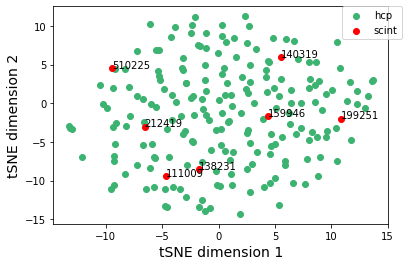

In [28]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

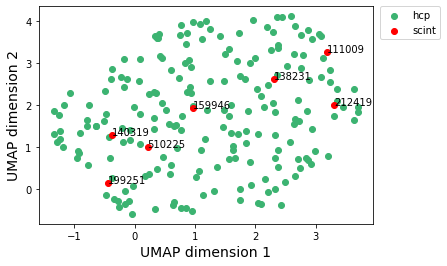

In [29]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_hcp)

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Outlier detection ML algorithm

In [14]:
average_fp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}
average_tp_list = {'oc': {k: [] for k in np.arange(0.05, 1, 0.1)}, 'if': {k: [] for k in np.arange(0.05, 1, 0.1)}}

for k in range(10):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_hcp)
    fp_list = {'oc':[], 'lof':[], 'if':[]}
    tp_list = {'oc':[], 'lof':[], 'if':[]}
    undetected_sub_oc = []
    undetected_sub_if = []
    fp_random = {}
    tp_random = {}

    for k in np.arange(0.05, 1, 0.1):
        tp_random[k] = []
        fp_random[k] = []
        clf = OneClassSVM(nu=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        #fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
        #tp_list['oc'].append(len(pred_scint[pred_scint==-1])/7)
        
        average_fp_list['oc'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['oc'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_oc.append(np.where(pred_scint==1))
        nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])

        clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
        pred_ctrl = clf.predict(embedding)[:200]
        pred_scint = clf.predict(embedding)[200:]
        
        average_fp_list['if'][k].append(len(pred_ctrl[pred_ctrl==-1])/200)
        average_tp_list['if'][k].append(len(pred_scint[pred_scint==-1])/7)
        
        undetected_sub_if.append(np.where(pred_scint==1))
        
        for i in range(1000):
            rand_outliers = np.array(random.sample(range(207), nb_outliers))
            tp_random[k].append(len(rand_outliers[rand_outliers>=200])/7)
            fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)
        
        
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

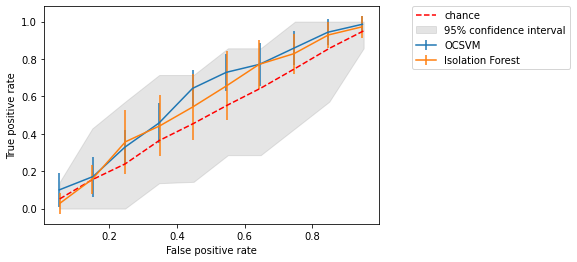

In [15]:
fp_oc = [np.mean(average_fp_list['oc'][k]) for k in average_fp_list['oc'].keys()]
tp_oc = [np.mean(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
error_oc = [np.std(average_tp_list['oc'][k]) for k in average_tp_list['oc'].keys()]
fp_if = [np.mean(average_fp_list['if'][k]) for k in average_fp_list['if'].keys()]
tp_if = [np.mean(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]
error_if = [np.std(average_tp_list['if'][k]) for k in average_tp_list['if'].keys()]

plt.subplot()
plt.errorbar(fp_oc, tp_oc, yerr=error_oc,label='OCSVM')
plt.errorbar(fp_if, tp_if, yerr=error_if, label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
#plt.legend()
plt.show()

(array([1., 0., 1., 0., 1., 1., 1., 0., 1., 1.]),
 array([34685. , 35177.9, 35670.8, 36163.7, 36656.6, 37149.5, 37642.4,
        38135.3, 38628.2, 39121.1, 39614. ]),
 <BarContainer object of 10 artists>)

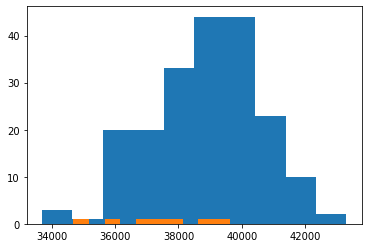

In [30]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)

In [17]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)
print(p)

0.032012441294931804


(array([2., 0., 0., 1., 0., 0., 1., 1., 1., 1.]),
 array([2485. , 2625.5, 2766. , 2906.5, 3047. , 3187.5, 3328. , 3468.5,
        3609. , 3749.5, 3890. ]),
 <BarContainer object of 10 artists>)

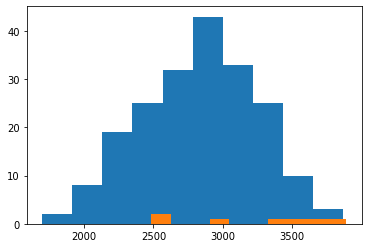

In [18]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)

In [19]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon, df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)
print(p)

0.033900373698943435


In [ ]:
for sub in scint_list:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

    out[out>0.7] = 1
    out[out<=0.7] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_out.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_in.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_error.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_error_2.bck")

### Loss of SC int more variable ?

In [22]:
loss = []

for k in range(5):
    tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                         loss_func=criterion, kl_weight=2,
                         n_latent=100, depth=3)

    results_hcp = tester_hcp.test()
    losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
    loss.append(losses_hcp['hcp'] + losses_hcp['scint'])
    print(losses_hcp['scint'])



hcp
scint
[3689, 3669, 3145, 2572, 2757, 3175, 3182]
hcp
scint
[3736, 3690, 3100, 2615, 2974, 3179, 3230]
hcp
scint
[3831, 3704, 3178, 2558, 2789, 3215, 3141]
hcp
scint
[3762, 3696, 3019, 2591, 2895, 3183, 3094]
hcp
scint
[3714, 3746, 2994, 2546, 2893, 3123, 3202]


In [29]:
print(np.mean(loss[0][:200]))
print(np.std(loss[0][:200]))
print('scint')
print(np.mean(loss[0][200:]))
print(np.std(loss[0][200:]))
print('round 2')
print(np.mean(loss[1][:200]))
print(np.std(loss[1][:200]))
print('scint')
print(np.mean(loss[1][200:]))
print(np.std(loss[1][200:]))
print('round 3')
print(np.mean(loss[2][:200]))
print(np.std(loss[2][:200]))
print('scint')
print(np.mean(loss[2][200:]))
print(np.std(loss[2][200:]))
print('round 4')
print(np.mean(loss[3][:200]))
print(np.std(loss[3][:200]))
print('scint')
print(np.mean(loss[3][200:]))
print(np.std(loss[3][200:]))

2697.66
329.4773958862732
scint
3169.8571428571427
386.80538797083125
round 2
2694.02
329.9101538297965
scint
3217.714285714286
364.46466193023207
round 3
2689.3
340.7140002993713
scint
3202.285714285714
420.4445654935514
round 4
2688.995
330.60623856031515
scint
3177.1428571428573
390.3102899604104
